To recognize 2 levels of cognitive load from a wearable wrist-band (Microsoft Band 2).

The dataset contains data from 23 participants, 5 of them for testing and 18 for training. The train and test data was generated using windows of 30 seconds.

Additional preprocessing steps (e.g., filtering) were not used in the preparation of the dataset, besides the sampling/resampling. Thus, the data is raw, as provided by the MicrosoftBand2.

**Accuracy** will be used as a metric for evaluation. The final evaluation will be performed at the
end of the competition.

Approaches that are taking into account the timeline of the data, i.e., the temporal dependence among the labels are not allowed, as it may mirror the experimental scenario and it would defeat the purpose of the challenge. For clarification, exploiting temporal dependence within instances, i.e., within the 30 seconds windows is allowed. Also, using User_ids for personalization is allowed.

In [54]:
import gc
import os
import random
import numpy as np
import pandas as pd
import dask
import dask.dataframe as dd
from scipy import stats

from matplotlib import pyplot as plt
import seaborn as sns
plt.rcParams['figure.figsize'] = (20,5)

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, RepeatedStratifiedKFold, train_test_split
from sklearn.metrics import accuracy_score as accuracy
from sklearn.ensemble import VotingClassifier, RandomForestClassifier, BaggingClassifier

import os
import random
import gc

In [2]:
SEED = 1729
def determinism(SEED=SEED):
    random.seed = SEED
    os.environ['PYTHONHASHSEED'] = str(SEED)
    np.random.seed = SEED
    print('done')
    
determinism()

done


# Reading Data

In [123]:
# Reading Training Data
'''
- gsr_train.csv - Galvanic skin response sampled at 1Hz.
- hr_train.csv - Heart Rate sampled at 1Hz.
- rr_train.csv - RR intervals resampled at 1Hz.
- temp_train.csv - Skin temperature sampled at 1Hz.
- labels_train.csv - The first column contains the data labels (0 - cognitive load, 1-resting). 
The second column contains the user_id.

Each file contains 632 lines x 30 columns, 
corresponding to 632 instances each containing 
30 samples (30 seconds at the sampling rate 1 Hz). 
The train instances are randomly permuted.
'''
# no missing values

gsr_train = pd.read_csv('train/gsr_train.csv', header=None) 
hr_train = pd.read_csv('train/hr_train.csv', header=None)
rr_train = pd.read_csv('train/rr_train.csv',header=None)
temp_train = pd.read_csv('train/temp_train.csv',header=None)
labels_train = pd.read_csv('train/labels_train.csv', header=None,
                          names = ['loaded','user-id'])

train_list = [gsr_train, hr_train, rr_train, temp_train]

#train_dd = dd.read_csv('train/*_train.csv', header=None)


In [4]:
labels_train = labels_train.astype({'loaded':'category'})

In [5]:
#labels_train.dtypes

In [6]:
for df in train_list:
    df['loaded'] = labels_train['loaded']
    df.index = labels_train['user-id']
    print(df.isna().sum().sum())

0
0
0
0


In [7]:
user_list = list(labels_train['user-id'].unique())
user_df = {}
sensors = ['gsr','hr','rr','temp']
train_df = {'gsr': gsr_train,
            'hr': hr_train,
            'rr': rr_train,
            'temp': temp_train}

In [8]:
train = pd.concat([gsr_train,hr_train,rr_train,temp_train])
iterables = [sensors,labels_train['user-id']]
train.index = pd.MultiIndex.from_product(iterables, names=['sensor', 'user-id'])

#train = pd.concat([gsr_train,hr_train,rr_train,temp_train], keys = ('gsr','hr','rr','temp'))
#train.index.names = ['sensor', 'user-id']
#train = train.swaplevel(i='user-id', j ='sensor')

In [9]:
train.head()

0         1         2         3         4         5  \
sensor user-id                                                               
gsr    5gpsc    1.594915  1.596633  1.599173  1.601720  1.607820  1.612109   
       wjxci    0.655883  0.656599  0.657755  0.658620  0.659052  0.658040   
       rc1in    1.047488  1.048219  1.046757  1.045664  1.044205  1.043841   
       ibvx8    1.618148  1.601077  1.589129  1.574009  1.567478  1.559263   
       yljm5    0.378287  0.380906  0.382021  0.382167  0.381875  0.381243   

                       6         7         8         9  ...        21  \
sensor user-id                                          ...             
gsr    5gpsc    1.610408  1.599188  1.594050  1.595751  ...  1.651074   
       wjxci    0.657175  0.656743  0.656743  0.656743  ...  0.369245   
       rc1in    1.043479  1.042754  1.042029  1.039868  ...  0.998356   
       ibvx8    1.555212  1.552805  1.547205  1.538512  ...  1.451379   
       yljm5    0.380952  0.380807  0.380325  0.379988  ...  0.376129   

                      22        23        24        25        26        27  \
sensor user-id                                                               
gsr    5gpsc    1.651983  1.654720  1.652905  1.650186  1.644740  1.647467   
       wjxci    0.376029  0.384373  0.396744  0.492764  0.586921  0.673100   
       rc1in    0.993391  0.989130  0.985875  0.982966  0.978498  0.965499   
       ibvx8    1.450678  1.449977  1.449977  1.452793  1.457031  1.464880   
       yljm5    0.376601  0.376932  0.376743  0.376553  0.376364  0.376223   

                      28        29  loaded  
sensor user-id                              
gsr    5gpsc    1.655705  1.666707       0  
       wjxci    0.671894  0.669798       1  
       rc1in    0.949937  0.938108       1  
       ibvx8    1.470614  1.474926       0  
       yljm5    0.375799  0.374909       1  

[5 rows x 31 columns]

In [10]:
for user in user_list:
    user_df[user] = train.xs(user, level='user-id')

In [11]:
gsr_train.head()

,0,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,loaded
user-id,,,,,,,,,,,,,,,,,,,,,
5gpsc,1.594915,1.596633,1.599173,1.601720,1.607820,1.612109,1.610408,1.599188,1.594050,1.595751,...,1.651074,1.651983,1.654720,1.652905,1.650186,1.644740,1.647467,1.655705,1.666707,0
wjxci,0.655883,0.656599,0.657755,0.658620,0.659052,0.658040,0.657175,0.656743,0.656743,0.656743,...,0.369245,0.376029,0.384373,0.396744,0.492764,0.586921,0.673100,0.671894,0.669798,1
rc1in,1.047488,1.048219,1.046757,1.045664,1.044205,1.043841,1.043479,1.042754,1.042029,1.039868,...,0.998356,0.993391,0.989130,0.985875,0.982966,0.978498,0.965499,0.949937,0.938108,1
ibvx8,1.618148,1.601077,1.589129,1.574009,1.567478,1.559263,1.555212,1.552805,1.547205,1.538512,...,1.451379,1.450678,1.449977,1.449977,1.452793,1.457031,1.464880,1.470614,1.474926,0
yljm5,0.378287,0.380906,0.382021,0.382167,0.381875,0.381243,0.380952,0.380807,0.380325,0.379988,...,0.376129,0.376601,0.376932,0.376743,0.376553,0.376364,0.376223,0.375799,0.374909,1


In [12]:
hr_train.head()

,0,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,loaded
user-id,,,,,,,,,,,,,,,,,,,,,
5gpsc,60.000000,60.666667,61.666667,62.000000,62.000000,62.000000,62.000000,62.000000,62.000000,62.000000,...,61.666667,61.333333,61.333333,63.000000,64.333333,65.333333,65.333333,65.666667,66.000000,0
wjxci,75.333333,75.666667,75.333333,75.000000,75.000000,75.000000,74.666667,74.000000,73.666667,73.666667,...,77.666667,75.666667,73.666667,72.000000,72.000000,71.666667,71.666667,71.666667,71.666667,1
rc1in,61.666667,62.333333,63.000000,63.000000,63.000000,63.000000,63.000000,63.000000,63.000000,63.000000,...,63.333333,63.000000,63.000000,63.000000,62.333333,61.000000,59.666667,58.666667,58.333333,1
ibvx8,77.333333,76.000000,75.333333,75.000000,75.000000,75.000000,75.000000,75.000000,75.000000,75.333333,...,76.000000,75.666667,75.666667,75.333333,75.333333,75.000000,74.000000,72.666667,71.666667,0
yljm5,76.000000,76.666667,77.333333,77.666667,77.666667,77.333333,76.666667,76.666667,76.333333,76.000000,...,76.333333,76.333333,76.000000,75.666667,67.666667,60.000000,52.000000,52.333333,52.666667,1


In [13]:
rr_train.head()

,0,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,loaded
user-id,,,,,,,,,,,,,,,,,,,,,
5gpsc,0.995520,0.984459,0.956805,0.934683,0.929152,0.945744,0.967867,0.978928,0.967867,0.956805,...,0.989989,0.978928,0.962336,0.907029,0.851723,0.829600,0.857253,0.901499,0.929152,0
wjxci,0.718987,0.768763,0.735579,0.779824,0.857253,0.940213,0.945744,0.851723,0.763232,0.741109,...,0.818539,0.813008,0.818539,0.846192,0.857253,0.790885,0.785355,0.813008,0.851723,1
rc1in,0.237819,0.199104,0.530944,0.956805,1.227808,1.106133,0.884907,0.829600,0.757701,0.829600,...,0.923621,0.956805,1.012112,1.050827,1.111664,1.144848,1.172501,1.211216,1.117195,1
ibvx8,0.818539,0.818539,0.813008,0.807477,0.796416,0.785355,0.774293,0.763232,0.752171,0.752171,...,0.829600,0.796416,0.807477,0.824069,0.846192,0.857253,0.840661,0.829600,0.801947,0
yljm5,0.680272,0.790885,0.779824,0.785355,0.835131,0.779824,0.790885,0.741109,0.785355,0.757701,...,0.790885,0.713456,0.575189,0.486699,0.326309,0.381616,0.387147,0.680272,0.796416,1


In [14]:
temp_train.head()

,0,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,loaded
user-id,,,,,,,,,,,,,,,,,,,,,
5gpsc,33.619999,33.619999,33.619999,33.619999,33.619999,33.619999,33.619999,33.619999,33.619999,33.619999,...,33.630001,33.630001,33.630001,33.630001,33.630001,33.630001,33.630001,33.630001,33.630001,0
wjxci,34.290001,34.290001,34.290001,34.290001,34.290001,34.290001,34.290001,34.290001,34.290001,34.290001,...,34.290001,34.290001,34.290001,34.290001,34.290001,34.290001,34.290001,34.290001,34.290001,1
rc1in,32.040001,32.040001,32.040001,32.040001,32.040001,32.040001,32.040001,32.040001,32.040001,32.046668,...,32.060001,32.060001,32.060001,32.060001,32.060001,32.060001,32.060001,32.060001,32.060001,1
ibvx8,35.009998,35.009998,35.009998,35.009998,35.006666,35.003333,35.000000,35.000000,35.000000,35.000000,...,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000,0
yljm5,31.900000,31.900000,31.900000,31.900000,31.900000,31.900000,31.900000,31.900000,31.900000,31.900000,...,31.900000,31.900000,31.900000,31.900000,31.900000,31.900000,31.900000,31.900000,31.900000,1


In [15]:
labels_train.set_index('user-id', drop=True, inplace=True)
labels_train.head()

,loaded
user-id,
5gpsc,0
wjxci,1
rc1in,1
ibvx8,0
yljm5,1


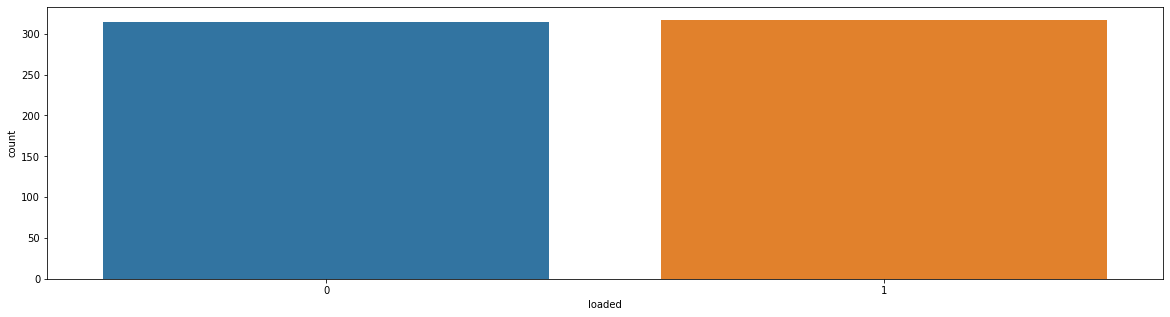

In [16]:
sns.countplot(labels_train['loaded'])

In [17]:
gsr_train.describe()

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
count,632.000000,632.000000,632.000000,632.000000,632.000000,632.000000,632.000000,632.000000,632.000000,632.000000,...,632.000000,632.000000,632.000000,632.000000,632.000000,632.000000,632.000000,632.000000,632.000000,632.000000
mean,1.921015,1.924157,1.925414,1.923948,1.922138,1.920860,1.920464,1.919416,1.919341,1.919709,...,1.917395,1.915631,1.915700,1.915777,1.915042,1.913176,1.911272,1.911536,1.913402,1.915452
std,1.807445,1.809548,1.809791,1.809769,1.809743,1.808023,1.806321,1.804564,1.804145,1.803984,...,1.798999,1.798657,1.799206,1.799068,1.798440,1.797150,1.795833,1.793844,1.792409,1.792538
min,0.024257,0.023915,0.023191,0.014619,0.009803,0.006245,0.002938,0.006162,0.008802,0.009376,...,0.024513,0.024684,0.024769,0.024855,0.024855,0.024855,0.024855,0.024769,0.024855,0.024940
25%,0.666015,0.664342,0.666410,0.665047,0.665236,0.662639,0.663755,0.667382,0.667423,0.658426,...,0.676113,0.677114,0.677825,0.677568,0.677015,0.677661,0.676973,0.676285,0.677729,0.680700
50%,1.328849,1.346504,1.342015,1.338733,1.335482,1.323691,1.330695,1.338245,1.338316,1.339808,...,1.317285,1.332296,1.343510,1.337089,1.326336,1.315808,1.309242,1.303786,1.322036,1.334436
75%,2.632274,2.611086,2.621681,2.636220,2.637381,2.632803,2.625386,2.620850,2.605327,2.595183,...,2.570697,2.555925,2.555885,2.562472,2.563878,2.569114,2.553198,2.554294,2.553217,2.551595
max,7.712488,7.751938,7.751938,7.732061,7.692611,7.653161,7.633588,7.633588,7.633884,7.633884,...,7.537784,7.518797,7.518797,7.519080,7.537784,7.537784,7.518797,7.537784,7.556771,7.595034


In [18]:
hr_train.describe()

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
count,632.000000,632.000000,632.000000,632.000000,632.000000,632.000000,632.000000,632.000000,632.000000,632.000000,...,632.000000,632.000000,632.000000,632.000000,632.000000,632.000000,632.000000,632.000000,632.000000,632.000000
mean,74.974947,74.985759,75.013186,75.063819,75.133703,75.176688,75.270833,75.355485,75.429852,75.418249,...,74.878692,74.848365,74.846255,74.818302,74.755011,74.653217,74.582806,74.529536,74.515559,74.515032
std,11.416113,11.426244,11.460606,11.518785,11.560380,11.519431,11.425671,11.449036,11.506171,11.486795,...,11.589609,11.572052,11.520022,11.399039,11.350883,11.387635,11.387077,11.430821,11.420807,11.432265
min,48.333333,48.666667,48.666667,48.333333,48.000000,48.000000,52.000000,52.000000,52.333333,52.333333,...,51.333333,51.000000,51.000000,51.000000,51.000000,49.000000,49.333333,50.000000,50.666667,51.333333
25%,67.333333,67.250000,67.333333,67.666667,67.625000,68.000000,68.000000,67.666667,68.000000,68.000000,...,67.666667,67.666667,67.666667,67.666667,67.250000,67.000000,67.000000,66.666667,66.916667,67.000000
50%,72.666667,73.000000,73.000000,73.666667,73.666667,73.500000,73.333333,73.333333,73.333333,73.333333,...,72.666667,72.666667,72.666667,72.666667,73.000000,72.666667,72.666667,72.666667,72.666667,72.750000
75%,79.666667,79.666667,79.666667,79.666667,79.666667,79.750000,80.000000,80.666667,80.750000,81.000000,...,80.000000,80.000000,80.000000,80.000000,80.000000,80.000000,80.000000,80.000000,79.666667,80.000000
max,116.000000,116.000000,115.333333,114.333333,116.000000,119.333333,120.666667,123.000000,124.666667,125.000000,...,123.333333,123.000000,122.000000,119.000000,116.666667,117.666667,118.000000,117.666667,117.000000,119.333333


In [19]:
 rr_train.describe()

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
count,632.000000,632.000000,632.000000,632.000000,632.000000,632.000000,632.000000,632.000000,632.000000,632.000000,...,632.000000,632.000000,632.000000,632.000000,632.000000,632.000000,632.000000,632.000000,632.000000,632.000000
mean,0.796062,0.794307,0.796976,0.797807,0.797611,0.798481,0.797256,0.798354,0.798035,0.802200,...,0.810190,0.809481,0.810265,0.811512,0.811870,0.810129,0.810820,0.811179,0.811477,0.806860
std,0.147198,0.147518,0.146535,0.143040,0.139748,0.140333,0.143471,0.143028,0.139162,0.137140,...,0.145208,0.142258,0.144540,0.142695,0.142111,0.141378,0.140781,0.141898,0.142273,0.143317
min,0.199104,0.199104,0.160389,0.243349,0.348432,0.337371,0.304187,0.337371,0.359493,0.248880,...,0.376085,0.398208,0.287595,0.243349,0.309717,0.326309,0.276533,0.176981,0.215696,0.226757
25%,0.696864,0.707925,0.713456,0.707925,0.706543,0.707925,0.702395,0.702395,0.707234,0.707925,...,0.702395,0.713456,0.713456,0.713456,0.713456,0.718987,0.713456,0.717604,0.707925,0.713456
50%,0.801947,0.801947,0.801947,0.807477,0.796416,0.796416,0.793651,0.796416,0.795033,0.801947,...,0.804712,0.807477,0.813008,0.810243,0.807477,0.813008,0.813008,0.813008,0.810243,0.801947
75%,0.901499,0.895968,0.890437,0.884907,0.895968,0.890437,0.890437,0.890437,0.890437,0.902881,...,0.916017,0.912560,0.907029,0.918091,0.918091,0.907029,0.901499,0.901499,0.901499,0.901499
max,1.150379,1.194624,1.255461,1.238869,1.227808,1.377136,1.531995,1.349483,1.150379,1.169736,...,1.233339,1.172501,1.194624,1.305237,1.305237,1.139317,1.216747,1.266523,1.272053,1.255461


In [20]:
temp_train.describe()

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
count,632.000000,632.000000,632.000000,632.000000,632.000000,632.000000,632.000000,632.000000,632.000000,632.000000,...,632.000000,632.000000,632.000000,632.000000,632.000000,632.000000,632.000000,632.000000,632.000000,632.000000
mean,32.657408,32.657803,32.658196,32.658811,32.659446,32.660100,32.660535,32.660883,32.661134,32.661366,...,32.664283,32.664546,32.664699,32.664705,32.664736,32.664755,32.664902,32.665092,32.665232,32.665332
std,1.339931,1.339475,1.339396,1.339243,1.338926,1.338652,1.338588,1.338622,1.338766,1.338777,...,1.338399,1.338239,1.338000,1.337840,1.337745,1.337595,1.337301,1.336976,1.336752,1.336411
min,28.730000,28.780001,28.780001,28.780001,28.780001,28.780001,28.780001,28.780001,28.780001,28.780001,...,28.780001,28.780001,28.780001,28.780001,28.780001,28.780001,28.780001,28.780001,28.780001,28.826667
25%,31.780001,31.780001,31.780001,31.780001,31.780001,31.780001,31.780001,31.780001,31.780001,31.780001,...,31.787501,31.787501,31.787501,31.787501,31.787501,31.787501,31.787501,31.787501,31.787501,31.785000
50%,32.610001,32.610001,32.610001,32.610001,32.610001,32.610001,32.610001,32.610001,32.610001,32.610001,...,32.610001,32.610001,32.610001,32.610001,32.610001,32.610001,32.610001,32.610001,32.610001,32.610001
75%,33.712500,33.712500,33.712500,33.720001,33.720001,33.720001,33.717500,33.712500,33.712500,33.712500,...,33.720001,33.720001,33.720001,33.720001,33.720001,33.720001,33.720001,33.720001,33.720001,33.720001
max,35.130001,35.130001,35.130001,35.130001,35.133334,35.136667,35.139999,35.139999,35.139999,35.139999,...,35.139999,35.139999,35.139999,35.139999,35.139999,35.139999,35.139999,35.139999,35.139999,35.139999


In [21]:
user_df.keys()

dict_keys(['5gpsc', 'wjxci', 'rc1in', 'ibvx8', 'yljm5', 'hpbxa', '7swyk', 'e4gay', 'ef5rq', '8a1ep', 'f3j25', 'tn4vl', '2nxs5', '1mpau', 'iz2ps', 'b7mrd', 'c24ur', 'dkhty'])

In [22]:
user_df[user_list[0]]

,0,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,loaded
sensor,,,,,,,,,,,,,,,,,,,,,
gsr,1.594915,1.596633,1.599173,1.601720,1.607820,1.612109,1.610408,1.599188,1.594050,1.595751,...,1.651074,1.651983,1.654720,1.652905,1.650186,1.644740,1.647467,1.655705,1.666707,0
gsr,2.053666,2.023601,1.983239,1.957088,1.941767,1.934255,1.926801,1.920626,1.925614,1.939414,...,1.983027,1.965931,1.965931,1.965931,1.967215,1.964642,1.959515,1.973980,1.999272,0
gsr,1.273989,1.292383,1.309039,1.311832,1.302717,1.294228,1.289227,1.284810,1.280415,1.277686,...,1.292296,1.285109,1.277977,1.273351,1.271187,1.269574,1.268501,1.266359,1.264759,0
gsr,1.533759,1.536115,1.536115,1.529861,1.522091,1.515172,1.509069,1.506026,1.505269,1.503766,...,1.452123,1.443721,1.440235,1.444436,1.466762,1.472363,1.479530,1.455832,1.465955,0
gsr,1.209701,1.203388,1.195269,1.187228,1.179723,1.173278,1.166894,1.160109,1.155192,1.150757,...,1.107840,1.102956,1.099313,1.104669,1.120596,1.134749,1.138977,1.132527,1.126988,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
temp,33.570000,33.570000,33.570000,33.570000,33.570000,33.570000,33.570000,33.570000,33.570000,33.570000,...,33.563333,33.556666,33.549999,33.549999,33.549999,33.549999,33.549999,33.549999,33.549999,0
temp,33.410000,33.410000,33.410000,33.410000,33.410000,33.410000,33.410000,33.410000,33.410000,33.410000,...,33.410000,33.410000,33.410000,33.410000,33.410000,33.410000,33.410000,33.410000,33.410000,0
temp,32.180000,32.180000,32.180000,32.180000,32.180000,32.180000,32.180000,32.180000,32.180000,32.180000,...,32.180000,32.180000,32.180000,32.180000,32.180000,32.180000,32.180000,32.220000,32.260000,1


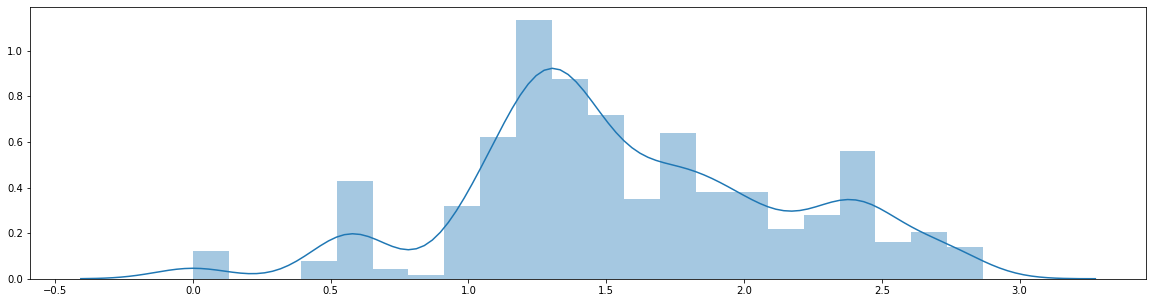

In [23]:
sns.distplot(user_df[user_list[0]].loc['gsr'])#[[1]])

# Test data

In [24]:
# Reading Testing Data
'''
Files:
- gsr_test.csv - Galvanic skin response sampled at 1Hz.
- hr_test.csv - Heart Rate sampled at 1Hz.
- rr_test.csv - RR intervals resampled at 1Hz.
- temp_test.csv - Skin temperature sampled at 1Hz.
- exampleTeam_predictions.csv - first column contains example predictions and it should be modified by the participants. The second column contains the user_id.

Each file contains 193 lines x 30 columns, 
corresponding to 193 instances each containing 
30 samples (30 seconds at the sampling rate 1 Hz). 
The test instances are randomly permuted.
'''
# No missing values
gsr_test = pd.read_csv('test/gsr_test.csv', header=None)
hr_test = pd.read_csv('test/hr_test.csv', header=None)
rr_test = pd.read_csv('test/rr_test.csv',header=None)
temp_test = pd.read_csv('test/temp_test.csv',header=None)
example_pred = pd.read_excel('test/exampleTeam_predictions.xlsx', header=None)


In [25]:
example_pred.head()

,0,1
0,0,bd47a
1,0,6frz4
2,0,iz3x1
3,0,3caqi
4,0,iz3x1


In [26]:
temp_test.head()

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,32.529999,32.529999,32.529999,32.529999,32.529999,32.529999,32.529999,32.549999,32.570000,32.590000,...,32.590000,32.590000,32.590000,32.590000,32.590000,32.590000,32.590000,32.590000,32.590000,32.590000
1,33.950001,33.950001,33.950001,33.950001,33.950001,33.950001,33.950001,33.950001,33.950001,33.950001,...,33.950001,33.950001,33.950001,33.950001,33.950001,33.950001,33.940000,33.929999,33.919998,33.919998
2,34.180000,34.180000,34.180000,34.180000,34.180000,34.180000,34.180000,34.180000,34.180000,34.180000,...,34.200001,34.200001,34.200001,34.200001,34.200001,34.200001,34.200001,34.200001,34.200001,34.200001
3,35.160000,35.160000,35.160000,35.160000,35.160000,35.160000,35.160000,35.160000,35.160000,35.160000,...,35.160000,35.160000,35.160000,35.160000,35.160000,35.160000,35.160000,35.160000,35.160000,35.160000
4,34.279999,34.279999,34.279999,34.279999,34.279999,34.279999,34.279999,34.279999,34.279999,34.279999,...,34.279999,34.279999,34.279999,34.279999,34.279999,34.279999,34.279999,34.279999,34.279999,34.279999


In [27]:
rr_test.head()

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,1.100603,1.084011,1.039765,1.034235,1.034235,1.067419,1.050827,1.045296,1.050827,1.034235,...,1.012112,1.023173,1.028704,1.072949,1.084011,1.095072,1.045296,1.039765,1.061888,1.067419
1,0.824069,0.813008,0.801947,0.575189,0.425861,0.293125,0.259941,0.331840,0.475637,0.663680,...,0.724517,0.707925,0.702395,0.702395,0.735579,0.702395,0.503291,0.536475,0.481168,0.707925
2,0.824069,0.829600,0.868315,0.790885,0.796416,0.790885,0.813008,0.768763,0.735579,0.702395,...,0.824069,0.807477,0.818539,0.801947,0.818539,0.801947,0.793651,0.754936,0.749405,0.752171
3,0.967867,1.012112,1.067419,1.089541,0.956805,0.984459,0.907029,0.862784,0.741109,0.746640,...,0.907029,0.868315,0.846192,0.835131,0.851723,0.813008,0.763232,0.735579,0.774293,0.608373
4,0.890437,0.907029,0.973397,1.039765,1.045296,0.940213,0.829600,0.696864,0.663680,0.696864,...,1.006581,0.962336,0.890437,0.862784,0.907029,0.907029,0.956805,0.912560,0.840661,0.724517


In [28]:
hr_test.head()

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,63.666667,63.000000,62.333333,61.666667,61.333333,60.666667,60.333333,59.666667,61.000000,62.000000,...,65.333333,66.666667,66.333333,65.000000,64.000000,62.666667,62.333333,64.333333,66.333333,68.000000
1,83.000000,82.333333,81.666667,81.333333,82.000000,82.666667,83.000000,83.333333,84.000000,84.333333,...,82.000000,82.000000,82.000000,82.000000,82.000000,82.000000,82.333333,82.666667,83.000000,83.000000
2,68.666667,69.333333,69.666667,71.666667,73.666667,75.000000,74.666667,73.666667,75.000000,76.333333,...,70.666667,71.000000,71.666667,72.333333,72.000000,72.000000,72.000000,72.000000,72.000000,74.666667
3,59.666667,60.000000,59.666667,59.333333,59.000000,59.000000,58.666667,58.666667,59.000000,59.666667,...,64.333333,67.000000,68.666667,69.666667,68.333333,69.333333,71.333333,73.666667,74.333333,74.333333
4,64.333333,64.666667,64.666667,65.000000,64.666667,66.666667,68.666667,71.333333,71.666667,72.000000,...,68.000000,67.666667,67.333333,67.666667,68.333333,68.666667,68.333333,68.000000,67.666667,67.666667


In [29]:
gsr_test.head()

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,6.451613,6.437827,6.424042,6.410256,6.410256,6.396647,6.383037,6.369427,6.369427,6.369427,...,6.369599,6.383037,6.369599,6.342552,6.315845,6.302577,6.289308,6.302577,6.302577,6.302577
1,1.708436,1.715360,1.744004,1.762999,1.780537,1.783777,1.796443,1.798577,1.794264,1.791046,...,1.719226,1.725131,1.723156,1.720198,1.704717,1.691263,1.704304,1.726830,1.734439,1.711758
2,2.433157,2.415609,2.397199,2.380068,2.368783,2.358499,2.360367,2.367854,2.367854,2.358605,...,2.257344,2.252260,2.248878,2.243839,2.235517,2.225551,2.218937,2.217295,2.214032,2.207534
3,2.795904,2.798512,2.803743,2.811656,2.816916,2.816916,2.811626,2.808989,2.808989,2.808989,...,2.801120,2.801120,2.798512,2.795904,2.795904,2.801135,2.803743,2.803743,2.801120,2.803743
4,2.992486,3.243803,3.484433,3.476506,3.433042,3.379021,3.333656,3.307640,3.300330,3.303973,...,3.147259,3.090337,3.036816,3.012176,3.006054,2.994244,2.970760,2.938369,2.915567,2.901441


In [30]:
#sns.countplot(gsr_train)

# Model

In [ ]:
import LogisticRegression()

In [98]:
LogisticRegression?

In [111]:
clf_gsr = LogisticRegression()
clf_hr = RandomForestClassifier()
clf_rr = LogisticRegression()
clf_temp = LogisticRegression()

clf_dict = {'gsr': clf_gsr,
      'hr': clf_hr,
      'rr': clf_rr,
      'temp': clf_temp}

#clf = BaggingClassifier()

In [120]:
X_train = {}
X_val = {}
y_train = labels_train[0:475]['loaded']
y_val = labels_train[475:]['loaded']
y_pred = {}
y_pred_proba = {}

In [122]:
for sensor in sensors:
    X_train[sensor] = train_df[sensor][0:475]
    X_val[sensor] = train_df[sensor][475:]
    X_train[sensor] = X_train[sensor].drop(columns='loaded')
    X_val[sensor] = X_val[sensor].drop(columns='loaded')
    
    clf_dict[sensor].fit(X_train[sensor], y_train)
    y_pred[sensor] = clf_dict[sensor].predict(X_val[sensor])
    y_pred_proba[sensor] = clf_dict[sensor].predict_proba(X_val[sensor])
    print(accuracy_score(y_val,y_pred[sensor]))

0.4394904458598726
0.5796178343949044
0.5477707006369427
0.4840764331210191


In [114]:
clf = VotingClassifier(estimators = [('gsr',clf_gsr),('hr',clf_hr),('rr',clf_rr),('temp',clf_temp)],
                       voting = 'hard'
                      )

In [115]:
#accuracy_score(y_val,clf.predict(X_val['gsr']))

In [116]:
thresh = 0.2
y = (y_pred['gsr'][0:,0] + y_pred['hr'][0:,0] + y_pred['rr'][0:,0] + y_pred['temp'][0:,0])/4

y[y>=thresh] = 1
y[y<thresh] = 0

In [117]:
accuracy(y_val,y)

0.554140127388535

In [58]:
y_train = train_gsr['loaded']
y_val = val_gsr['loaded']
train_gsr.drop(columns='loaded',inplace=True)
val_gsr.drop(columns='loaded',inplace=True)

In [59]:
clf.fit(train_gsr,y_train)

LogisticRegression()

In [61]:
y_pred = clf.predict(val_gsr)

In [62]:
accuracy_score(y_val,y_pred)

0.4394904458598726

 # Bug in Pandas / Sklearn?

In [ ]:
df = pd.DataFrame(np.random.randn(10, 5), columns=['a', 'b', 'c', 'd', 'e'])

X_train, X_test = train_test_split(df, test_size = 0.1)
X_train2, X_test2 = train_test_split(df, test_size = 0.1)

In [181]:
X_train

NameError: name 'X_train' is not defined

In [182]:
X_test

NameError: name 'X_test' is not defined

In [183]:
X_train2

NameError: name 'X_train2' is not defined

In [184]:
X_test2

NameError: name 'X_test2' is not defined